In [200]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Constants and hyperparameters

In [201]:
epochs = 500 # Number of training epochs
batch_size = 12 # Batch size
split_percentage = 0.8 # Training and test set splitting percentage
validation_split = 0.2 # Validation set percentage
early_stopping_patience = 20 # Number of epochs of patience before triggering early stopping

In [202]:
dataset_path = "../Dataset/Sensors/Parallel/Multiple Naca/parallel_section__100_bins__multiple_naca__y.npz" # Dataset path
labels = ["y"] # Name of the labels
flow_field = "p" # Flow quantity to be used as input feature

### Data loading

In [203]:
# Loading the data
dataset = np.load(dataset_path)
dataset = list(zip(dataset[flow_field], *[dataset[label] for label in labels]))

In [204]:
#dataset = [sample for sample in dataset if sample[2] <= -50 or sample[2] >= 50]

In [205]:
print(len(dataset))

12000


### Shuffling the dataset

In [206]:
# Shuffling the dataset
np.random.shuffle(dataset)

### Features and labels

In [207]:
# Extracting the features and the labels from the dataset
X, *Y = zip(*dataset)
X, Y = np.array(X), np.array(Y).T

### Training and test set

In [208]:
# Computing the number of training samples according to the splitting percentage
num_training_samples = int(np.floor(split_percentage * len(dataset)))

In [209]:
# Extracting the training features and labels
X_train = np.expand_dims(X[:num_training_samples], axis=2)
Y_train = Y[:num_training_samples]

# Extracting the test features and labels
X_test = np.expand_dims(X[num_training_samples:], axis=2)
Y_test = Y[num_training_samples:]

### Data normalization

In [210]:
# Computing the mean and standard deviation of the training features
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

In [211]:
# Function to normalize the features
def normalize(x):
    x = (x - mean) / std
    return x

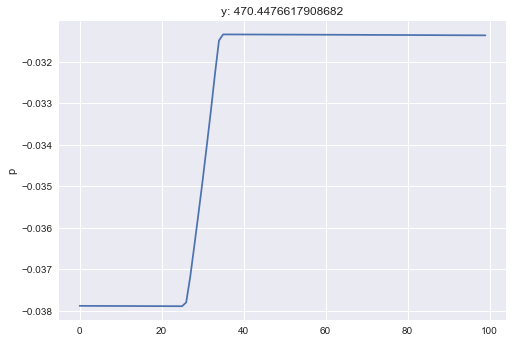

In [212]:
# Plotting a random sample
choice = np.random.randint(0, (len(X_train)-1))
plt.title(f'{"".join([(labels[i] + ": " + str(Y_train[choice][i]) + (" | " if i < len(labels) - 1 else "")) for i in range(len(labels))])}')
plt.ylabel(flow_field)
plt.plot(X_train[choice])
plt.show()

### Building the model

In [213]:

# BEST MODEL FOR SECTIONS X = [-1c, 2c]
def buildModel():
  # Sequential model - CNN 1D
  model = keras.Sequential([
    keras.layers.InputLayer(input_shape=np.shape(X_train)[1:]),
    keras.layers.Lambda(normalize), # Normalization layer
    keras.layers.Conv1D(filters=24, kernel_size=3, activation=tf.nn.tanh, padding="same"),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(60, tf.nn.tanh),
    keras.layers.Dense(30, tf.nn.tanh),
    keras.layers.Dense(30, tf.nn.tanh),
    keras.layers.Dense(30, tf.nn.tanh),
    keras.layers.Dense(np.shape(Y)[1])
  ])

  # Compiling the model
  model.compile(loss='mse', optimizer="adam", metrics=['mae'])
  
  return model

In [214]:

# BEST MODEL FOR SECTION X = 11c
def buildModel2():
  # Sequential model - CNN 1D
  model = keras.Sequential([
    keras.layers.InputLayer(input_shape=np.shape(X_train)[1:]),
    keras.layers.Lambda(normalize), # Normalization layer
    keras.layers.Conv1D(filters=12, kernel_size=3, activation=tf.nn.tanh),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=8, kernel_size=3, activation=tf.nn.tanh),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(30, tf.nn.tanh),
    keras.layers.Dense(20, tf.nn.tanh),
    keras.layers.Dense(10, tf.nn.tanh),
    keras.layers.Dense(np.shape(Y)[1])
  ])

  # Compiling the model
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  
  return model

In [215]:
model = buildModel()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_8 (Lambda)            (None, 100, 1)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 100, 24)           96        
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 50, 24)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 60)                72060     
_________________________________________________________________
dense_41 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_42 (Dense)             (None, 30)               

### Model training

In [216]:
# Early stopping with a predefined patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=early_stopping_patience,
    restore_best_weights=True,
    verbose=True
)

# Training the model
history = model.fit(
    X_train, 
    Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    shuffle=True,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/500
640/640 [==============================] - 5s 7ms/step - loss: 90442.6484 - mae: 256.4684 - val_loss: 85356.1875 - val_mae: 247.1700
Epoch 2/500
640/640 [==============================] - 4s 6ms/step - loss: 81611.5469 - mae: 240.1581 - val_loss: 76814.5547 - val_mae: 231.5646
Epoch 3/500
640/640 [==============================] - 4s 6ms/step - loss: 73767.5391 - mae: 225.6954 - val_loss: 69305.6250 - val_mae: 217.7010
Epoch 4/500
640/640 [==============================] - 4s 6ms/step - loss: 66358.1719 - mae: 212.3612 - val_loss: 62543.8789 - val_mae: 205.1571
Epoch 5/500
640/640 [==============================] - 4s 7ms/step - loss: 61011.8242 - mae: 201.7126 - val_loss: 58522.6680 - val_mae: 196.4013
Epoch 6/500
640/640 [==============================] - 4s 7ms/step - loss: 55622.5586 - mae: 191.5231 - val_loss: 52912.8242 - val_mae: 185.9548
Epoch 7/500
640/640 [==============================] - 4s 7ms/step - loss: 49612.9414 - mae: 181.3034 - val_loss: 46900.9102 - val

In [217]:
# Function to plot the metrics of training and validation
def plotHistory(history, training_metric, validation_metric, ylabel):
  plt.plot(history.history[training_metric], label=training_metric)
  plt.plot(history.history[validation_metric], label=validation_metric)
  plt.ylim([0, np.max(history.history[training_metric] + history.history[validation_metric])])
  plt.xlabel('Epoch')
  plt.ylabel(ylabel)
  plt.grid(True)
  plt.legend()
  plt.show()

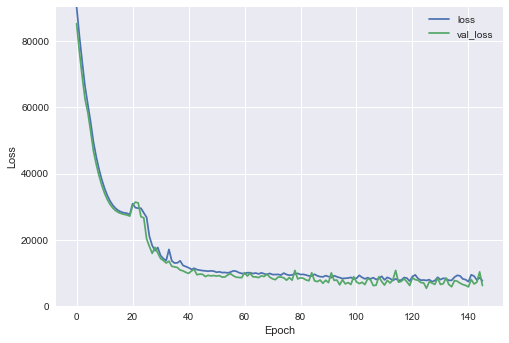

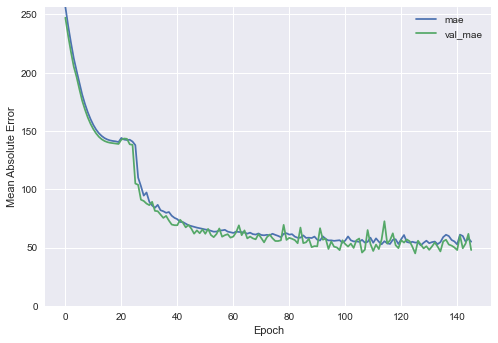

In [218]:
plotHistory(history, 'loss', 'val_loss', "Loss")
plotHistory(history, 'mae', 'val_mae', "Mean Absolute Error")

### Model evaluation

In [219]:
# Computing the predictions of the test set
predictions = model.predict(X_test)

In [220]:
def regressionMetrics(predictions, labels):
    # Creating an array to save the results
    mses, maes = np.zeros(np.shape(Y)[1]), np.zeros(np.shape(Y)[1])

    # Computing the Mean absolute error
    for idx in range(np.shape(Y)[1]):
        # Computing the Mean Absolute Error of the current NACA number
        mae = np.mean(np.absolute(predictions[:,idx] - labels[:,idx]))
        mse = ((predictions[:,idx] - labels[:,idx])**2).mean(axis=0)

        # Adding the result to the array
        mses[idx], maes[idx] = mse, mae

    return mses, maes

In [221]:
# Computing the regression errors: MSE and MAE
mse, mae = regressionMetrics(predictions, Y_test)

print("REGRESSION")
print(f" - Loss (Mean Square Error) --> {np.mean(mse)}")
print(f" - Mean Absolute Error --> {np.mean(mae)}")
for i in range(len(labels)):
    print(f"   • {labels[i]} --> MSE: {mse[i]} | MAE: {mae[i]}")


REGRESSION
 - Loss (Mean Square Error) --> 6359.177694270325
 - Mean Absolute Error --> 48.72071062039175
   • y --> MSE: 6359.177694270325 | MAE: 48.72071062039175


In [222]:

# Function to plot the predicted values
def plotPredictions(test_labels, test_predictions, min_value, max_value, label, color):
  plt.scatter(test_labels, test_predictions, label=label, color=color)
  plt.xlabel('True values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim([min_value, max_value])
  plt.ylim([min_value, max_value])
  plt.plot([min_value, max_value], [min_value, max_value], color="black")
  plt.legend()

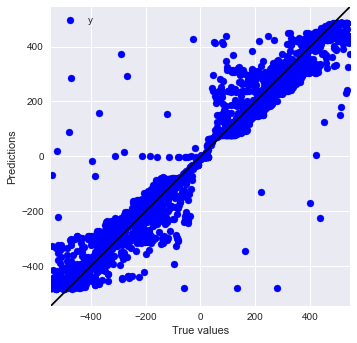

In [223]:
colors = ["blue", "green", "orange"]
max_value = np.max(Y_test.flatten())
min_value = np.min(Y_test.flatten())

plt.style.use('seaborn')

# Plotting the obtained results
for i in range(np.shape(Y)[1]):
  plotPredictions(Y_test[:,i], predictions[:,i], min_value, max_value, label=labels[i], color=colors[i])